# Incorporate marine species to NRC
### In this notebook we incorporate marine data to the updated terrestrial data calculated in the Terrestrial_NRC notebook
May 2022

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import arcgis
from arcgis.gis import GIS
import json
import pandas as pd
from arcgis.features import FeatureLayerCollection
import requests as re
from copy import deepcopy
from itertools import repeat
import functools

## Import, explore and prepare the data

In [2]:
path = '/Users/sofia/Documents/HE_Data/NRC/NRC_Marine'

In [4]:
# Import tables
gadm = pd.read_csv('/Users/sofia/Documents/HE_Data/NRC/NRC_Terrestrial/NRC_Terrestrial_final.csv') # This is the updated gadm_centroid
spi = pd.read_csv(f'{path}/Marine_SPI_by_country_20220603_v2.csv')# table with spi and protection
mar = pd.read_csv(f'{path}/NRC_Species_Data_20220603_v2.csv') # Species able provided by Alex (MOL)
perc = pd.read_csv(f'{path}/marine_protection_and_protection_needed.csv')
pop = pd.read_csv(f'{path}/Pop2020_eez.csv') # calculated in arcgis pro using the population2020.crf and the EEZ shapefile
hm = pd.read_csv(f'{path}/marine_perc_human.csv') # human modification table
eez = gpd.read_file(f'{path}/eez_centroids/eez_centroids.shp')

In [5]:
gadm.head(1)

,Unnamed: 0,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,...,birds,mammals,reptiles,endemic_amphibians,endemic_birds,endemic_mammals,endemic_reptiles,nspecies_ter,total_endemic_ter,filter_similar_ter
0,0,ABW,Aruba,181.938403,"POLYGON ((-69.9782 12.4699, -70.0121 12.4904, ...",-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,...,193,4,32,0,0,0,3,232,3,"{""filter_Area_Country"": [""JEY"", ""CXR"", ""WLF"", ..."


In [6]:
gadm.continent.unique()

array(['North America', 'Asia', 'Africa', 'Europe', 'South America',
       'Oceania', 'Antarctica', nan], dtype=object)

In [7]:
gadm.continent[gadm.GID_0=='UMI']

252    NaN
Name: continent, dtype: object

In [8]:
gadm.continent[gadm.GID_0=='UMI']= 'North America'
gadm.continent[gadm.GID_0=='UMI']

/var/folders/98/0pdnjc5s29x2pnzl293pw7hr0000gn/T/ipykernel_2321/1036630463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gadm.continent[gadm.GID_0=='UMI']= 'North America'


252    North America
Name: continent, dtype: object

In [9]:
len(gadm)

254

In [10]:
spi.head(1)

,SOVEREIGN1,iso_ter1,year,nspecies,SPI_low,SPI_high,percentprotected_low,percentprotected_high,GID_0,ObjectId
0,Australia,HMD,1986,350.0,0.0,0.0,0.0,0.0,HMD,1.0


In [11]:
len(spi['iso_ter1'].unique()) # There are 202 unique countries/territories with SPI data

202

In [12]:
spi.SOVEREIGN1[spi.iso_ter1=='MUS'].unique()

array(['Republic of Mauritius'], dtype=object)

In [13]:
mar.head(1)

,Unnamed: 0,speciesgroup,species,countryname,iso3,percentprotected,NSPS,stewardship
0,1,marine fishes,Abalistes filamentosus,Australia,AUS,25-50%,75-100,29


In [14]:
len(mar['iso3'].unique()) # There are 199 unique countries/territories with marine species

199

In [15]:
mar.countryname[mar.iso3=='MUS'].unique()

array(['Mauritius', 'Republic of Mauritius'], dtype=object)

There are two different countrynames associated with the same iso3. MOL wants to keep only the data related to "Republic of Mauritius", so let's remove the "Mauritius" data.

In [16]:
len(mar)

338839

In [17]:
mar = mar[mar.countryname != 'Mauritius']
len(mar)

336001

In [18]:
mar.countryname[mar.iso3=='MUS'].unique()

array(['Republic of Mauritius'], dtype=object)

In [19]:
mar.head(5)

,Unnamed: 0,speciesgroup,species,countryname,iso3,percentprotected,NSPS,stewardship
0,1,marine fishes,Abalistes filamentosus,Australia,AUS,25-50%,75-100,29
1,2,marine fishes,Abalistes filamentosus,East Timor,TLS,0-25%,0-25,29
2,3,marine fishes,Abalistes filamentosus,Fiji,FJI,0-25%,50-75,29
3,4,marine fishes,Abalistes filamentosus,France,FRA,25-50%,75-100,29
4,5,marine fishes,Abalistes filamentosus,Indonesia,IDN,0-25%,25-50,29


In [20]:
perc.head()

,Unnamed: 0,ISO_TER1_F,Perc_Prot_Need,Perc_Prot
0,1,ABW,7.356267,0.005504
1,2,AGO,7.608244,0.011753
2,3,AIA,1.264193,1.430093
3,4,ALB,32.743156,0.804740
4,5,ARE,56.964522,7.070762


In [21]:
len(perc)

203

In [22]:
pop.head(1)

,OID_,GID_0,ZONE_CODE,COUNT,AREA,SUM
0,1,ABW,1,55.0,0.003819,1547.605201


In [23]:
len(pop) # There are 201 countries/territories that have population in their EEZ

201

In [24]:
hm.head(1)

,Unnamed: 0,ISO_TER1_F,no_human,human,very_high
0,2,ABW,0.0,0.783047,0.216953


In [25]:
len(hm) # There are 203 countries/territories that have human modification data in their EEZ

203

In [26]:
eez.head()

,GID_0,AREA_KM,ORIG_FID,geometry
0,ABW,29970.299588,1,POINT (-69.67341 13.74138)
1,AGO,495859.762742,2,POINT (11.03537 -11.70110)
2,AIA,90157.964205,3,POINT (-62.54329 20.01803)
3,ALB,12165.548773,4,POINT (19.11300 40.92708)
4,ARE,57838.146798,5,POINT (54.03058 25.05891)


In [27]:
len(eez) # There are 202 countries/territories that have EEZ

202

In [28]:
gadm.columns

Index(['Unnamed: 0', 'GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y',
       'jpg_url', 'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter'],
      dtype='object')

**Clean tables**

In [29]:
# There are more hm countries than eez countries??
list1 = list(eez['GID_0'].unique())
list2 = list(hm['ISO_TER1_F'].unique())
list(set(list2).difference(list1)) # 'TMP' not present in gadm or eez 

['TMP']

In [30]:
hm[hm.ISO_TER1_F=='TMP']

,Unnamed: 0,ISO_TER1_F,no_human,human,very_high
181,183,TMP,0.00166,0.0,0.99834


In [31]:
hm = hm.drop(index=[181])
len(hm)

202

In [32]:
# There are more hm countries than eez countries??
list1 = list(eez['GID_0'].unique())
list2 = list(perc['ISO_TER1_F'].unique())
list(set(list2).difference(list1)) # 'TMP' not present in gadm or eez 

['TMP']

In [33]:
perc[perc.ISO_TER1_F=='TMP']

,Unnamed: 0,ISO_TER1_F,Perc_Prot_Need,Perc_Prot
181,182,TMP,0.0,0.545805


In [34]:
perc = perc.drop(index=[181])
len(perc)

202

In [35]:
# Find GID_0 that are in species table but not in gadm 
list1= list(gadm['GID_0'])
list2=list(mar['iso3'].unique())
list(set(list2).difference(list1))  # XXZ is international waters

['XXZ']

In [36]:
# Remove 'XXZ'
l = list(set(list2).difference(list1))
mar = mar[~mar['iso3'].isin(l)]
len(mar.iso3.unique())

198

In [37]:
# Find GID_0 that are in spi table but not in gadm:
list1= list(gadm['GID_0'])
list2=list(spi['iso_ter1'].unique())
list(set(list2).difference(list1)) 

['XXZ']

In [38]:
# Remove 'XXZ'
l = list(set(list2).difference(list1))
spi = spi[~spi['iso_ter1'].isin(l)]
len(spi.iso_ter1.unique())

201

In [39]:
# Find GID_0 that are in hm but not in gadm:
list1= list(gadm['GID_0'])
list2=list(hm['ISO_TER1_F'].unique())
list(set(list2).difference(list1)) 

[]

In [40]:
# Find GID_0 that are in population but not in gadm:
list1= list(gadm['GID_0'])
list2=list(pop['GID_0'].unique())
list(set(list2).difference(list1)) 

[]

In [41]:
# Find GID_0 that are in EEZ table but not in gadm
list1= list(gadm['GID_0'])
list2=list(eez['GID_0'].unique())
list(set(list2).difference(list1)) 

[]

**Create "Marine" field in gadm table to identify countries that have eez and those that are only terrestrial**

In [42]:
# Create list with countries that have eez
l = list(eez['GID_0'])
len(eez)

202

In [43]:
# Give true or false to marine field according to the presence of eez
gadm['Marine'] = gadm['GID_0'].apply(lambda x: any([k in x for k in l]))
gadm['Marine'] = gadm['Marine'].map({True: 'True', False: 'False'})
type(gadm['Marine'][0])

str

**Prepare tables**

In [44]:
# Change name of human modification fields to prepare it for join
hm = hm.rename(columns={'ISO_TER1_F':'GID_0', 'no_human':'hm_no_mar', 'human':'hm_mar', 'very_high':'hm_vh_mar'}).drop(columns= {'Unnamed: 0'})
hm.head()

,GID_0,hm_no_mar,hm_mar,hm_vh_mar
0,ABW,0.000000,0.783047,0.216953
1,AGO,0.000223,0.778475,0.221302
2,AIA,0.000000,0.943677,0.056323
3,ALB,0.000263,0.003746,0.995991
4,ARE,0.000116,0.034045,0.965838


In [45]:
# The human modification table was given in 0-1 values, let's make it in % to match the terrestrial data
hm['hm_no_mar'] = hm['hm_no_mar'].apply(lambda x: x*100)
hm['hm_mar'] = hm['hm_mar'].apply(lambda x: x*100)
hm['hm_vh_mar'] = hm['hm_vh_mar'].apply(lambda x: x*100)
hm.head()

,GID_0,hm_no_mar,hm_mar,hm_vh_mar
0,ABW,0.000000,78.304750,21.695250
1,AGO,0.022313,77.847478,22.130209
2,AIA,0.000000,94.367741,5.632259
3,ALB,0.026286,0.374581,99.599133
4,ARE,0.011637,3.404538,96.583825


In [46]:
hm = hm.round(2)
hm.head()

,GID_0,hm_no_mar,hm_mar,hm_vh_mar
0,ABW,0.00,78.30,21.70
1,AGO,0.02,77.85,22.13
2,AIA,0.00,94.37,5.63
3,ALB,0.03,0.37,99.60
4,ARE,0.01,3.40,96.58


In [47]:
pop.head()

,OID_,GID_0,ZONE_CODE,COUNT,AREA,SUM
0,1,ABW,1,55.0,0.003819,1547.605201
1,2,AGO,2,1577.0,0.109514,350682.727157
2,3,AIA,3,85.0,0.005903,1693.719824
3,4,ALB,4,363.0,0.025208,13744.754178
4,5,ARE,5,1677.0,0.116458,145877.628456


In [48]:
# Change name pop fields to prepare it for join
pop = pop.drop(columns={'OID_', 'ZONE_CODE', 'COUNT', 'AREA'}).rename(columns = {'SUM':'Pop2020_EEZ'})
pop.head(2)

,GID_0,Pop2020_EEZ
0,ABW,1547.605201
1,AGO,350682.727157


In [49]:
pop = pop.round(2)
pop.head()

,GID_0,Pop2020_EEZ
0,ABW,1547.61
1,AGO,350682.73
2,AIA,1693.72
3,ALB,13744.75
4,ARE,145877.63


In [50]:
eez = eez.rename(columns={'AREA_KM':'Area_EEZ'}).drop(columns='ORIG_FID')
eez.head()

,GID_0,Area_EEZ,geometry
0,ABW,29970.299588,POINT (-69.67341 13.74138)
1,AGO,495859.762742,POINT (11.03537 -11.70110)
2,AIA,90157.964205,POINT (-62.54329 20.01803)
3,ALB,12165.548773,POINT (19.11300 40.92708)
4,ARE,57838.146798,POINT (54.03058 25.05891)


------------------------------------------------------------------------------------------------------------------
## Overview tab: generate general information
### Add Population data 
Population by EEZ was calculated in ArcGIS Pro using the EEZ_dissolved (by GID_0) shp and the population2020.crf

In [45]:
gadm.columns

Index(['Unnamed: 0', 'GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y',
       'jpg_url', 'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine'],
      dtype='object')

In [43]:
len(pop)

201

In [51]:
# Create new dataframe and add new population data 
df = pd.merge(gadm, pop,  how='left', left_on=['GID_0'], right_on = ['GID_0']).drop(columns={'Unnamed: 0'})
df.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine', 'Pop2020_EEZ'],
      dtype='object')

In [45]:
len(df)

254

In [52]:
df[df.GID_0=='ATA']

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,reptiles,endemic_amphibians,endemic_birds,endemic_mammals,endemic_reptiles,nspecies_ter,total_endemic_ter,filter_similar_ter,Marine,Pop2020_EEZ
11,ATA,Antarctica,1.236505e+07,"MULTIPOLYGON (((-99.8479 -74.9229, -99.8917 -7...",20.814124,-80.561889,https://live.staticflickr.com/1590/25126847203...,1.0,0.0,31d4f242-3c5b-4e94-bc65-e288880d9dda,...,0,0,0,0,0,97,0,"{""filter_Area_Country"": [""COD"", ""KAZ"", ""ARG"", ...",True,NaN


In [53]:
df.Pop2020_EEZ[df.GID_0=='ATA']=0
df[df.GID_0=='ATA']

/var/folders/98/0pdnjc5s29x2pnzl293pw7hr0000gn/T/ipykernel_2321/2444116394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Pop2020_EEZ[df.GID_0=='ATA']=0


,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,reptiles,endemic_amphibians,endemic_birds,endemic_mammals,endemic_reptiles,nspecies_ter,total_endemic_ter,filter_similar_ter,Marine,Pop2020_EEZ
11,ATA,Antarctica,1.236505e+07,"MULTIPOLYGON (((-99.8479 -74.9229, -99.8917 -7...",20.814124,-80.561889,https://live.staticflickr.com/1590/25126847203...,1.0,0.0,31d4f242-3c5b-4e94-bc65-e288880d9dda,...,0,0,0,0,0,97,0,"{""filter_Area_Country"": [""COD"", ""KAZ"", ""ARG"", ...",True,0.0


### Add human modification data

In [54]:
hm.head()

,GID_0,hm_no_mar,hm_mar,hm_vh_mar
0,ABW,0.00,78.30,21.70
1,AGO,0.02,77.85,22.13
2,AIA,0.00,94.37,5.63
3,ALB,0.03,0.37,99.60
4,ARE,0.01,3.40,96.58


In [55]:
len(hm)

202

In [56]:
# Add human modification data
df= pd.merge(df, hm ,how='left', left_on=['GID_0'], right_on = ['GID_0'])
df.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,endemic_mammals,endemic_reptiles,nspecies_ter,total_endemic_ter,filter_similar_ter,Marine,Pop2020_EEZ,hm_no_mar,hm_mar,hm_vh_mar
0,ABW,Aruba,181.938403,"POLYGON ((-69.9782 12.4699, -70.0121 12.4904, ...",-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,0,3,232,3,"{""filter_Area_Country"": [""JEY"", ""CXR"", ""WLF"", ...",True,1547.61,0.0,78.3,21.7


### Add SPI
MOL sent a first version with these values, which is in https://eowilson.maps.arcgis.com/home/item.html?id=d48f5ea1e59a42048f57e4c44c1a82a3. However, in this case they grouped the EEZ by sovereign1, so they didn't match the terrestrial NRC, which are divided by territories (French Guiana is shown independently from France). So MOL sent a new table dividing the EEZ by iso_ter1 (when this was null they used the field iso_sov1). This was done for both tables (SPI&Protection and species)

In [57]:
# Take the last value (2021) for the general overview
last = spi[spi['year']==2021].copy()
last.head(5)

,SOVEREIGN1,iso_ter1,year,nspecies,SPI_low,SPI_high,percentprotected_low,percentprotected_high,GID_0,ObjectId
5,Australia,AUS,2021,6495.0,77.84,77.84,43.74,43.74,AUS,6.0
79,Argentina,ARG,2021,671.0,7.00,7.00,9.25,9.25,ARG,80.0
101,Antarctica,ATA,2021,121.0,50.79,50.79,35.55,35.55,ATA,102.0
156,Antigua and Barbuda,ATG,2021,1519.0,9.04,9.04,0.30,0.30,ATG,157.0
219,Australia,CCK,2021,1814.0,1.88,1.88,0.01,0.01,CCK,220.0


In [52]:
len(last)

201

In [58]:
# Take only relevant fields and change their names (include marine in name to distinguish them from terrestrial)
last = last[['GID_0','SPI_high']]
last = last.rename(columns= {'SPI_high':'SPI_mar'})
last.head(1)

,GID_0,SPI_mar
5,AUS,77.84


In [59]:
# Add SPI 
df= pd.merge(df, last ,how='left', left_on=['GID_0'], right_on = ['GID_0'])
df.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,endemic_reptiles,nspecies_ter,total_endemic_ter,filter_similar_ter,Marine,Pop2020_EEZ,hm_no_mar,hm_mar,hm_vh_mar,SPI_mar
0,ABW,Aruba,181.938403,"POLYGON ((-69.9782 12.4699, -70.0121 12.4904, ...",-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,3,232,3,"{""filter_Area_Country"": [""JEY"", ""CXR"", ""WLF"", ...",True,1547.61,0.0,78.3,21.7,0.0


#### Add percentage protected and percentage protection needed

In [60]:
perc.head()

,Unnamed: 0,ISO_TER1_F,Perc_Prot_Need,Perc_Prot
0,1,ABW,7.356267,0.005504
1,2,AGO,7.608244,0.011753
2,3,AIA,1.264193,1.430093
3,4,ALB,32.743156,0.804740
4,5,ARE,56.964522,7.070762


In [61]:
perc = perc.rename(columns={'ISO_TER1_F':'GID_0', 'Perc_Prot_Need':'protection_needed_mar', 'Perc_Prot':'prop_protected_mar'})
perc.head()

,Unnamed: 0,GID_0,protection_needed_mar,prop_protected_mar
0,1,ABW,7.356267,0.005504
1,2,AGO,7.608244,0.011753
2,3,AIA,1.264193,1.430093
3,4,ALB,32.743156,0.804740
4,5,ARE,56.964522,7.070762


In [62]:
perc = perc.round(2)
perc.head()

,Unnamed: 0,GID_0,protection_needed_mar,prop_protected_mar
0,1,ABW,7.36,0.01
1,2,AGO,7.61,0.01
2,3,AIA,1.26,1.43
3,4,ALB,32.74,0.80
4,5,ARE,56.96,7.07


In [63]:
len(perc)

202

In [64]:
# Add protection needed and % protection
df= pd.merge(df, perc ,how='left', left_on=['GID_0'], right_on = ['GID_0'])
df.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,filter_similar_ter,Marine,Pop2020_EEZ,hm_no_mar,hm_mar,hm_vh_mar,SPI_mar,Unnamed: 0,protection_needed_mar,prop_protected_mar
0,ABW,Aruba,181.938403,"POLYGON ((-69.9782 12.4699, -70.0121 12.4904, ...",-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,"{""filter_Area_Country"": [""JEY"", ""CXR"", ""WLF"", ...",True,1547.61,0.0,78.3,21.7,0.0,1.0,7.36,0.01


In [65]:
df = df.drop(columns='Unnamed: 0')
df.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,total_endemic_ter,filter_similar_ter,Marine,Pop2020_EEZ,hm_no_mar,hm_mar,hm_vh_mar,SPI_mar,protection_needed_mar,prop_protected_mar
0,ABW,Aruba,181.938403,"POLYGON ((-69.9782 12.4699, -70.0121 12.4904, ...",-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,3,"{""filter_Area_Country"": [""JEY"", ""CXR"", ""WLF"", ...",True,1547.61,0.0,78.3,21.7,0.0,7.36,0.01


### Calculate number of marine species and endemic species
This info comes from MOL

In [66]:
mar.head(1)

,Unnamed: 0,speciesgroup,species,countryname,iso3,percentprotected,NSPS,stewardship
0,1,marine fishes,Abalistes filamentosus,Australia,AUS,25-50%,75-100,29


In [67]:
## Get number of species (by taxa) per country
mar2 = mar[['speciesgroup', 'species', 'iso3']]
mar_num = mar2.groupby(by = ['speciesgroup', 'iso3']).count().reset_index()
mar_num.head(5)

,speciesgroup,iso3,species
0,marine fishes,ABW,1648
1,marine fishes,AGO,1372
2,marine fishes,AIA,1508
3,marine fishes,ALB,345
4,marine fishes,ARE,1138


In [68]:
## Distinguish between taxa
mamm = mar_num[mar_num['speciesgroup']=='marine mammals']
fish = mar_num[mar_num['speciesgroup']=='marine fishes']

In [69]:
mamm.head(5)

,speciesgroup,iso3,species
198,marine mammals,ABW,30
199,marine mammals,AGO,46
200,marine mammals,AIA,25
201,marine mammals,ALB,2
202,marine mammals,ARE,4


In [70]:
fish.head(5)

,speciesgroup,iso3,species
0,marine fishes,ABW,1648
1,marine fishes,AGO,1372
2,marine fishes,AIA,1508
3,marine fishes,ALB,345
4,marine fishes,ARE,1138


In [71]:
## Include number of species in dataframe
df2= pd.merge(df, mamm,  how='left', left_on=['GID_0'], right_on = ['iso3']).drop(columns = {'speciesgroup','iso3'}).rename(columns={'species': 'mammals_mar'})
df2= pd.merge(df2, fish,  how='left', left_on=['GID_0'], right_on = ['iso3']).drop(columns = {'speciesgroup','iso3'}).rename(columns={'species': 'fishes_mar'})
df2.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,Marine,Pop2020_EEZ,hm_no_mar,hm_mar,hm_vh_mar,SPI_mar,protection_needed_mar,prop_protected_mar,mammals_mar,fishes_mar
0,ABW,Aruba,181.938403,"POLYGON ((-69.9782 12.4699, -70.0121 12.4904, ...",-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,True,1547.61,0.0,78.3,21.7,0.0,7.36,0.01,30.0,1648.0


In [72]:
## Calculate number of endemic species per country: mammals
mamm_e = mar[(mar['speciesgroup']=='marine mammals')&(mar['stewardship']==1)]
mamm_e = mamm_e.groupby(['speciesgroup','iso3']).sum()
mamm_e = mamm_e.reset_index().rename(columns={'stewardship':'endemic_mammals_mar'}).drop(columns='Unnamed: 0')
mamm_e.head(5)

,speciesgroup,iso3,endemic_mammals_mar
0,marine mammals,AUS,1
1,marine mammals,ECU,2
2,marine mammals,NZL,1
3,marine mammals,USA,1


In [73]:
## Calculate number of endemic species per country: fishes
fish_e = mar[(mar['speciesgroup']=='marine fishes')&(mar['stewardship']==1)]
fish_e = fish_e.groupby(['speciesgroup','iso3']).sum()
fish_e = fish_e.reset_index().rename(columns={'stewardship':'endemic_fishes_mar'}).drop(columns='Unnamed: 0')
fish_e.head(5)

,speciesgroup,iso3,endemic_fishes_mar
0,marine fishes,AGO,2
1,marine fishes,ARG,2
2,marine fishes,ATA,5
3,marine fishes,ATF,2
4,marine fishes,AUS,362


In [74]:
## Merge endemic data in dataframe
df2= pd.merge(df2, mamm_e,  how='left', left_on=['GID_0'], right_on = ['iso3']).drop(columns = {'speciesgroup','iso3'})
df2= pd.merge(df2, fish_e,  how='left', left_on=['GID_0'], right_on = ['iso3']).drop(columns = {'speciesgroup','iso3'})
df2.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,hm_no_mar,hm_mar,hm_vh_mar,SPI_mar,protection_needed_mar,prop_protected_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar
0,ABW,Aruba,181.938403,"POLYGON ((-69.9782 12.4699, -70.0121 12.4904, ...",-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,0.0,78.3,21.7,0.0,7.36,0.01,30.0,1648.0,NaN,NaN


In [75]:
df2.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine', 'Pop2020_EEZ', 'hm_no_mar', 'hm_mar',
       'hm_vh_mar', 'SPI_mar', 'protection_needed_mar', 'prop_protected_mar',
       'mammals_mar', 'fishes_mar', 'endemic_mammals_mar',
       'endemic_fishes_mar'],
      dtype='object')

In [76]:
l1 = df2[(df2['Marine']== 'True') & (df2['mammals_mar'].isna()) & (df2['fishes_mar'].isna())].GID_0 # countries that have eez without species
l1

16     AZE
103    GIB
136    KAZ
241    TKM
Name: GID_0, dtype: object

In [77]:
## Make columns type integer
cols = ['mammals_mar', 'endemic_mammals_mar', 'fishes_mar', 'endemic_fishes_mar']
df2[cols] = df2[cols].fillna(0) 
df2[cols] = df2[cols].astype(int)

## Calculate total number of species and total number of endemic marine
df2['nspecies_mar']= df2['mammals_mar'] + df2['fishes_mar']
df2['total_endemic_mar']= df2['endemic_mammals_mar']+ df2['endemic_fishes_mar']
df2.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,hm_vh_mar,SPI_mar,protection_needed_mar,prop_protected_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar
0,ABW,Aruba,181.938403,"POLYGON ((-69.9782 12.4699, -70.0121 12.4904, ...",-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,21.7,0.0,7.36,0.01,30,1648,0,0,1678,0


In [78]:
df2['mammals_mar'] = np.where(df2['GID_0'].isin(l1), np.nan, df2['mammals_mar'])
df2['endemic_mammals_mar'] = np.where(df2['GID_0'].isin(l1), np.nan, df2['endemic_mammals_mar'])
df2['fishes_mar'] = np.where(df2['GID_0'].isin(l1), np.nan, df2['fishes_mar'])
df2['endemic_fishes_mar'] = np.where(df2['GID_0'].isin(l1), np.nan, df2['endemic_fishes_mar'])
df2['nspecies_mar'] = np.where(df2['GID_0'].isin(l1), np.nan, df2['nspecies_mar'])
df2['total_endemic_mar'] = np.where(df2['GID_0'].isin(l1), np.nan, df2['total_endemic_mar'])

In [79]:
df2[df2.GID_0=='TKM']

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,hm_vh_mar,SPI_mar,protection_needed_mar,prop_protected_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar
241,TKM,Turkmenistan,489592.93645,"MULTIPOLYGON (((52.8697 40.7828, 52.8762 40.78...",59.180302,39.192596,https://upload.wikimedia.org/wikipedia/commons...,1.0,0.0,49de4a11-9e56-4e34-98a6-2cce1e32882d,...,6.94,0.0,44.26,1.57,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
df2.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine', 'Pop2020_EEZ', 'hm_no_mar', 'hm_mar',
       'hm_vh_mar', 'SPI_mar', 'protection_needed_mar', 'prop_protected_mar',
       'mammals_mar', 'fishes_mar', 'endemic_mammals_mar',
       'endemic_fishes_mar', 'nspecies_mar', 'total_endemic_mar'],
      dtype='object')

In [81]:
# How many countries have marine data?
len(df2[~df2['nspecies_mar'].isna()]) # 250

250

In [82]:
# How many countries do not have marine data?
len(df2[df2['nspecies_mar'].isna()]) # 4

4

In [83]:
# How many countries do not have eez?
len(df2[df2['Marine']=='False'])

52

In [84]:
# How many countries have eez without species?
len(df2[(df2['Marine']== 'True') & (df2['nspecies_mar'].isna())]) # only 4 territories with EEZ but no species

4

In [85]:
l1 = df2[(df2['Marine']== 'True') & (df2['nspecies_mar'].isna())].GID_0 # countries that have eez without species
l1

16     AZE
103    GIB
136    KAZ
241    TKM
Name: GID_0, dtype: object

In [86]:
# How many countries have eez without spi?
len(df[(df2['Marine']== 'True') & (df2['SPI_mar'].isnull())])

1

In [87]:
l2 = df2[(df2['Marine']== 'True') & (df2['SPI_mar'].isnull())].NAME_0 # countries that have eez without spi
l2

103    Gibraltar
Name: NAME_0, dtype: object

### Add Area of eez

In [88]:
eez.head()

,GID_0,Area_EEZ,geometry
0,ABW,29970.299588,POINT (-69.67341 13.74138)
1,AGO,495859.762742,POINT (11.03537 -11.70110)
2,AIA,90157.964205,POINT (-62.54329 20.01803)
3,ALB,12165.548773,POINT (19.11300 40.92708)
4,ARE,57838.146798,POINT (54.03058 25.05891)


In [89]:
len(eez)

202

In [90]:
eez2 = eez[['GID_0', 'Area_EEZ']]
eez2.head()

,GID_0,Area_EEZ
0,ABW,29970.299588
1,AGO,495859.762742
2,AIA,90157.964205
3,ALB,12165.548773
4,ARE,57838.146798


In [91]:
eez2 = eez2.round(2)
eez2

,GID_0,Area_EEZ
0,ABW,29970.30
1,AGO,495859.76
2,AIA,90157.96
3,ALB,12165.55
4,ARE,57838.15
...,...,...
197,VUT,623418.75
198,WLF,262750.80
199,WSM,130475.81
200,YEM,527382.64


In [92]:
df2 = pd.merge(left = df2, right = eez2, left_on = "GID_0", right_on = "GID_0", how = "left")
df2.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine', 'Pop2020_EEZ', 'hm_no_mar', 'hm_mar',
       'hm_vh_mar', 'SPI_mar', 'protection_needed_mar', 'prop_protected_mar',
       'mammals_mar', 'fishes_mar', 'endemic_mammals_mar',
       'endemic_fishes_mar', 'nspecies_mar', 'total_endemic_mar', 'Area_EEZ'],
      dtype='object')

In [93]:
df2.head(2)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,SPI_mar,protection_needed_mar,prop_protected_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar,Area_EEZ
0,ABW,Aruba,181.938403,"POLYGON ((-69.9782 12.4699, -70.0121 12.4904, ...",-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,0.0,7.36,0.01,30.0,1648.0,0.0,0.0,1678.0,0.0,29970.3
1,AFG,Afghanistan,643857.477165,"POLYGON ((68.5746 31.7349, 68.5556 31.7144, 68...",66.029601,33.828432,https://p1.pxfuel.com/preview/967/12/53/afghan...,1.0,0.0,193ba976-0e5a-4cf6-9b09-d00bf83f4557,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN


#### Add global SPI marine
Given by MOL 23.40

In [94]:
df2['Global_SPI_mar']= np.where(df2['Marine']=='True', '23.40', np.nan)
df2.head(2)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,protection_needed_mar,prop_protected_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar,Area_EEZ,Global_SPI_mar
0,ABW,Aruba,181.938403,"POLYGON ((-69.9782 12.4699, -70.0121 12.4904, ...",-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,7.36,0.01,30.0,1648.0,0.0,0.0,1678.0,0.0,29970.3,23.40
1,AFG,Afghanistan,643857.477165,"POLYGON ((68.5746 31.7349, 68.5556 31.7144, 68...",66.029601,33.828432,https://p1.pxfuel.com/preview/967/12/53/afghan...,1.0,0.0,193ba976-0e5a-4cf6-9b09-d00bf83f4557,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,nan


#### Make species fields integer

In [96]:
cols = ['mammals_mar', 'fishes_mar', 'endemic_mammals_mar', 'endemic_fishes_mar', 'nspecies_mar', 'total_endemic_mar']
df2[cols] = df2[cols].fillna(0) 
df2[cols] = df2[cols].astype(int)

In [97]:
df2.head(2)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,protection_needed_mar,prop_protected_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar,Area_EEZ,Global_SPI_mar
0,ABW,Aruba,181.938403,"POLYGON ((-69.9782 12.4699, -70.0121 12.4904, ...",-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,7.36,0.01,30,1648,0,0,1678,0,29970.3,23.40
1,AFG,Afghanistan,643857.477165,"POLYGON ((68.5746 31.7349, 68.5556 31.7144, 68...",66.029601,33.828432,https://p1.pxfuel.com/preview/967/12/53/afghan...,1.0,0.0,193ba976-0e5a-4cf6-9b09-d00bf83f4557,...,NaN,NaN,0,0,0,0,0,0,NaN,nan


---------------------------------------------------------------------------------------------------------------------------------------------
## Process to create the challenges tab (create array with similar filters)
### Create matrix to identify countries with shared stewardship to create the stewardship filter
This code is more efficient than that described in the notebook "shared_stewardship", which was used during the first iteration of the NRC

In [98]:
mar.head()

,Unnamed: 0,speciesgroup,species,countryname,iso3,percentprotected,NSPS,stewardship
0,1,marine fishes,Abalistes filamentosus,Australia,AUS,25-50%,75-100,29
1,2,marine fishes,Abalistes filamentosus,East Timor,TLS,0-25%,0-25,29
2,3,marine fishes,Abalistes filamentosus,Fiji,FJI,0-25%,50-75,29
3,4,marine fishes,Abalistes filamentosus,France,FRA,25-50%,75-100,29
4,5,marine fishes,Abalistes filamentosus,Indonesia,IDN,0-25%,25-50,29


In [99]:
# Create a copy with only the species name and the iso3
mar2 = mar[['iso3','species']].copy()
mar2.head(5)

,iso3,species
0,AUS,Abalistes filamentosus
1,TLS,Abalistes filamentosus
2,FJI,Abalistes filamentosus
3,FRA,Abalistes filamentosus
4,IDN,Abalistes filamentosus


In [100]:
%%time
# Create a matrix that has, for each country, the number of shared species with each of the other countries
m = mar2.merge(mar2, on='species') # perform a self-merge based on the species
mat = pd.crosstab(m.iso3_x, m.iso3_y) # perform crosstabulation operation
mat.reset_index(inplace=True)
mat= mat.rename(columns = {'iso3_x':'index'})
mat.head(5)

CPU times: user 4.32 s, sys: 1.47 s, total: 5.79 s
Wall time: 6.07 s


iso3_y,index,ABW,AGO,AIA,ALB,ARE,ARG,ASM,ATA,ATF,...,VCT,VEN,VGB,VIR,VNM,VUT,WLF,WSM,YEM,ZAF
0,ABW,1678,595,1469,61,133,243,302,5,1602,...,1499,1675,1462,1481,307,372,359,324,116,515
1,AGO,595,1418,538,138,209,283,335,9,2591,...,560,607,533,545,407,448,406,369,179,1050
2,AIA,1469,538,1533,58,118,204,301,4,1428,...,1374,1499,1517,1516,274,353,355,319,111,462
3,ALB,61,138,58,347,31,38,24,0,195,...,59,61,57,58,36,28,27,27,23,99
4,ARE,133,209,118,31,1142,50,335,0,2805,...,132,133,117,124,823,522,375,435,1023,816


In [101]:
mat.shape 

(198, 199)

In [51]:
# Save local copy
# mat.to_csv('/Users/sofia/Documents/HE_Data/NRC/NRC_Marine/stewardship_matrix.csv',index=False)

### Get shared stewardship countries
Using the stewardship matrix. 

In [102]:
mat.columns.values

array(['index', 'ABW', 'AGO', 'AIA', 'ALB', 'ARE', 'ARG', 'ASM', 'ATA',
       'ATF', 'ATG', 'AUS', 'BEL', 'BEN', 'BES', 'BGD', 'BGR', 'BHR',
       'BHS', 'BIH', 'BLM', 'BLZ', 'BMU', 'BRA', 'BRB', 'BRN', 'CAN',
       'CCK', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK', 'COL',
       'COM', 'CPV', 'CRI', 'CUB', 'CUW', 'CXR', 'CYM', 'CYP', 'DEU',
       'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH',
       'ESP', 'EST', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB',
       'GBR', 'GEO', 'GGY', 'GHA', 'GIN', 'GLP', 'GMB', 'GNB', 'GNQ',
       'GRC', 'GRD', 'GRL', 'GTM', 'GUF', 'GUM', 'GUY', 'HMD', 'HND',
       'HRV', 'HTI', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR',
       'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KEN', 'KHM', 'KIR', 'KNA',
       'KOR', 'KWT', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LTU', 'LVA',
       'MAF', 'MAR', 'MCO', 'MDG', 'MDV', 'MEX', 'MHL', 'MLT', 'MMR',
       'MNE', 'MNP', 'MOZ', 'MRT', 'MSR', 'MTQ', 'MUS', 'MYS', 'MYT',
       'NAM', 'NCL

In [103]:
mat.columns.values[1:200]

array(['ABW', 'AGO', 'AIA', 'ALB', 'ARE', 'ARG', 'ASM', 'ATA', 'ATF',
       'ATG', 'AUS', 'BEL', 'BEN', 'BES', 'BGD', 'BGR', 'BHR', 'BHS',
       'BIH', 'BLM', 'BLZ', 'BMU', 'BRA', 'BRB', 'BRN', 'CAN', 'CCK',
       'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK', 'COL', 'COM',
       'CPV', 'CRI', 'CUB', 'CUW', 'CXR', 'CYM', 'CYP', 'DEU', 'DJI',
       'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP',
       'EST', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR',
       'GEO', 'GGY', 'GHA', 'GIN', 'GLP', 'GMB', 'GNB', 'GNQ', 'GRC',
       'GRD', 'GRL', 'GTM', 'GUF', 'GUM', 'GUY', 'HMD', 'HND', 'HRV',
       'HTI', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA',
       'JAM', 'JEY', 'JOR', 'JPN', 'KEN', 'KHM', 'KIR', 'KNA', 'KOR',
       'KWT', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LTU', 'LVA', 'MAF',
       'MAR', 'MCO', 'MDG', 'MDV', 'MEX', 'MHL', 'MLT', 'MMR', 'MNE',
       'MNP', 'MOZ', 'MRT', 'MSR', 'MTQ', 'MUS', 'MYS', 'MYT', 'NAM',
       'NCL', 'NFK',

In [104]:
# Get only the values (skip index)
df_mat = mat[mat.columns.values[1:200]]
df_mat.head(5)

iso3_y,ABW,AGO,AIA,ALB,ARE,ARG,ASM,ATA,ATF,ATG,...,VCT,VEN,VGB,VIR,VNM,VUT,WLF,WSM,YEM,ZAF
0,1678,595,1469,61,133,243,302,5,1602,1461,...,1499,1675,1462,1481,307,372,359,324,116,515
1,595,1418,538,138,209,283,335,9,2591,538,...,560,607,533,545,407,448,406,369,179,1050
2,1469,538,1533,58,118,204,301,4,1428,1506,...,1374,1499,1517,1516,274,353,355,319,111,462
3,61,138,58,347,31,38,24,0,195,58,...,59,61,57,58,36,28,27,27,23,99
4,133,209,118,31,1142,50,335,0,2805,121,...,132,133,117,124,823,522,375,435,1023,816


In [105]:
# set index using countries
df_mat = df_mat.set_index(mat['index'].values) 
df_mat.head(5)

iso3_y,ABW,AGO,AIA,ALB,ARE,ARG,ASM,ATA,ATF,ATG,...,VCT,VEN,VGB,VIR,VNM,VUT,WLF,WSM,YEM,ZAF
ABW,1678,595,1469,61,133,243,302,5,1602,1461,...,1499,1675,1462,1481,307,372,359,324,116,515
AGO,595,1418,538,138,209,283,335,9,2591,538,...,560,607,533,545,407,448,406,369,179,1050
AIA,1469,538,1533,58,118,204,301,4,1428,1506,...,1374,1499,1517,1516,274,353,355,319,111,462
ALB,61,138,58,347,31,38,24,0,195,58,...,59,61,57,58,36,28,27,27,23,99
ARE,133,209,118,31,1142,50,335,0,2805,121,...,132,133,117,124,823,522,375,435,1023,816


In [106]:
df_mat.columns = mat['index'].values
df_mat.head(5)

,ABW,AGO,AIA,ALB,ARE,ARG,ASM,ATA,ATF,ATG,...,VCT,VEN,VGB,VIR,VNM,VUT,WLF,WSM,YEM,ZAF
ABW,1678,595,1469,61,133,243,302,5,1602,1461,...,1499,1675,1462,1481,307,372,359,324,116,515
AGO,595,1418,538,138,209,283,335,9,2591,538,...,560,607,533,545,407,448,406,369,179,1050
AIA,1469,538,1533,58,118,204,301,4,1428,1506,...,1374,1499,1517,1516,274,353,355,319,111,462
ALB,61,138,58,347,31,38,24,0,195,58,...,59,61,57,58,36,28,27,27,23,99
ARE,133,209,118,31,1142,50,335,0,2805,121,...,132,133,117,124,823,522,375,435,1023,816


In [107]:
# Now it has the same shape
df_mat.shape

(198, 198)

In [108]:
# Create stewardship dictionary: for each country identify the 10 countries that share more species with it
df_sort = df_mat.copy()
steward_dict = dict.fromkeys(df_sort.columns.values)
for key in steward_dict:
    df_sort = df_sort.sort_values(by = [key], ascending=False)
    sub = df_sort[key][1:11] # to skip the same country
    vals = sub.index.values.tolist()
    vals.append(key)
    
    steward_dict[key] = json.dumps(vals)

In [109]:
# Convert stewardship dictionary into dataframe
steward_df = pd.DataFrame(steward_dict.items(), columns = ["GID_0","filter_steward"])
steward_df.head(5)

,GID_0,filter_steward
0,ABW,"[""PRI"", ""UMI"", ""ABW"", ""VEN"", ""CUW"", ""NLD"", ""CO..."
1,AGO,"[""SHN"", ""UMI"", ""BES"", ""AGO"", ""ZAF"", ""FRA"", ""PR..."
2,AIA,"[""PRI"", ""UMI"", ""AIA"", ""GBR"", ""DOM"", ""USA"", ""FR..."
3,ALB,"[""GRC"", ""ITA"", ""MNE"", ""ESP"", ""HRV"", ""DZA"", ""FR..."
4,ARE,"[""UMI"", ""ERI"", ""ARE"", ""IRN"", ""SAU"", ""OMN"", ""SO..."


In [110]:
steward_df.shape

(198, 2)

### Get nearest EEZ
Similar to what was done in the Terrestrial_NRC notebook for the countries' centroids: the idea here is to find, for each of the displayed EEZ, the closest ones using the distance between their centroids. 

Note that the original EEZ layer often has several EEZ associated with the same GID_0 (being GID_0 the iso_ter1 or, when this is missing, the iso_sov1). This leads to problems when trying to match the EEZ and the country polygons currently displayed in the NRC. For this reason, using ArcGIS Pro, we first dissolved the EEZ layer according to the GID_0 field, so that all polygons with same GID_0 code were considered as 1. Then, the centroids were calculated using the "Feature to Point tool". The centroids were not forced to fall within the feature since most are made of several polygons and forcing the centroid to fall just in one of them can lead to weird situation such as the centroid of the Spanish EEZ falling in the Canary Islands. For this reason, the "inside" option of the tool was disabled and the resulting centroids are located at the center of all the polygons conforming each of those EEZ, even if thar means that they fall, somethimes, outside the corresponding EEZ (in the ocean or even in a different EEZ)

In [111]:
from math import radians
import pandas as pd
import numpy as np
from sklearn.metrics import DistanceMetric

In [112]:
eez.head()

,GID_0,Area_EEZ,geometry
0,ABW,29970.299588,POINT (-69.67341 13.74138)
1,AGO,495859.762742,POINT (11.03537 -11.70110)
2,AIA,90157.964205,POINT (-62.54329 20.01803)
3,ALB,12165.548773,POINT (19.11300 40.92708)
4,ARE,57838.146798,POINT (54.03058 25.05891)


In [113]:
len(eez)

202

In [114]:
eez['Longitude'] = eez.geometry.x
eez['Latitude'] = eez.geometry.y

In [115]:
eez.head()

,GID_0,Area_EEZ,geometry,Longitude,Latitude
0,ABW,29970.299588,POINT (-69.67341 13.74138),-69.673412,13.741380
1,AGO,495859.762742,POINT (11.03537 -11.70110),11.035371,-11.701098
2,AIA,90157.964205,POINT (-62.54329 20.01803),-62.543285,20.018030
3,ALB,12165.548773,POINT (19.11300 40.92708),19.113001,40.927084
4,ARE,57838.146798,POINT (54.03058 25.05891),54.030580,25.058911


In [116]:
df_coord = pd.DataFrame(data = eez[['GID_0']])
len(df_coord)

202

In [117]:
df_coord.head()

,GID_0
0,ABW
1,AGO
2,AIA
3,ALB
4,ARE


In [118]:
# Get the coordinates of each EEZ centroid
y_list = []
x_list = []
for index, i in eez.iterrows():
    y_list.append(i['Latitude'])
    x_list.append(i['Longitude'])
    
df_coord['x'] = x_list
df_coord['y'] = y_list
df_coord.head(5)

,GID_0,x,y
0,ABW,-69.673412,13.741380
1,AGO,11.035371,-11.701098
2,AIA,-62.543285,20.018030
3,ALB,19.113001,40.927084
4,ARE,54.030580,25.058911


In [119]:
# Convert the coordinates to radians
df_coord['lat'] = np.radians(df_coord['y'])
df_coord['lon'] = np.radians(df_coord['x'])
df_coord.head(5)

,GID_0,x,y,lat,lon
0,ABW,-69.673412,13.741380,0.239832,-1.216030
1,AGO,11.035371,-11.701098,-0.204223,0.192604
2,AIA,-62.543285,20.018030,0.349381,-1.091586
3,ALB,19.113001,40.927084,0.714312,0.333585
4,ARE,54.030580,25.058911,0.437361,0.943012


In [120]:
# Get distance metric and use it to calculate the distance between coordinates of each country
dist = DistanceMetric.get_metric('haversine')
dist_df = pd.DataFrame(dist.pairwise(df_coord[['lat','lon']].to_numpy())*6373,  columns=df_coord.GID_0.unique(), index=df_coord.GID_0.unique())
dist_df.head(5)

,ABW,AGO,AIA,ALB,ARE,ARG,ASM,ATA,ATF,ATG,...,VCT,VEN,VGB,VIR,VNM,VUT,WLF,WSM,YEM,ZAF
ABW,0.000000,9337.734978,1030.808723,8914.511641,12547.816812,6807.636739,11363.979416,10402.096103,14419.463293,1119.079832,...,865.554410,419.428711,921.115430,641.667561,17196.124674,13781.883918,11735.482146,11743.613019,12950.292114,11709.958023
AGO,9337.734978,0.000000,8788.020528,5912.482037,6200.347364,7791.008092,17178.766459,6778.021008,5947.825120,8548.075782,...,8486.363636,8918.319824,8996.091257,8943.236001,11097.523707,16020.016864,17264.212124,17209.599342,5289.556005,3447.906848
AIA,1030.808723,8788.020528,0.000000,7885.881036,11527.545191,7464.512951,12230.890200,10872.544121,14304.121273,251.553043,...,768.373044,880.534088,208.905758,396.759468,16376.658731,14630.528192,12582.531107,12595.968453,11985.848882,11508.891880
ALB,8914.511641,5912.482037,7885.881036,0.000000,3670.470318,12645.491889,16907.327294,12690.409407,10176.126307,7809.772415,...,8290.467684,8669.939067,8022.311156,8273.171738,9138.476890,16035.353774,16685.064151,16738.656936,4467.695397,8856.152641
ARE,12547.816812,6200.347364,11527.545191,3670.470318,0.000000,13972.846658,15354.787082,11798.337743,7500.825686,11431.579298,...,11862.212594,12270.933759,11674.109276,11906.979081,5928.339267,13212.308320,14938.473077,14961.932367,1369.323080,7497.564528


In [121]:
dist_df.shape

(202, 202)

In [122]:
# Sort the table for each point. 0 values correspond to the same country, so take the 1:11 and add the row names to a dictionary to have the names of the 10 closest EEZ. 
dist_df_sort = dist_df.copy()
neighbour_dict = dict.fromkeys(dist_df_sort.columns.values)
for key in neighbour_dict:
    dist_df_sort = dist_df_sort.sort_values(by = [key]) # sort countries from closest to farthest
    sub = dist_df_sort[key][1:11] # keep the 10 closest ones but skip the same country (0 distance)
    vals = sub.index.values.tolist() # take the values
    neighbour_dict[key] = json.dumps(vals) # include them in dictionary

In [123]:
# Convert neighboring dictionary into dataframe
neigh_df = pd.DataFrame(neighbour_dict.items(), columns = ["GID_0","filter_neigh"])
neigh_df.head(5)

,GID_0,filter_neigh
0,ABW,"[""CUW"", ""BES"", ""VEN"", ""PRI"", ""DOM"", ""HTI"", ""VI..."
1,AGO,"[""COD"", ""COG"", ""GAB"", ""GNQ"", ""NAM"", ""STP"", ""CM..."
2,AIA,"[""VGB"", ""MAF"", ""BLM"", ""SXM"", ""ATG"", ""KNA"", ""VI..."
3,ALB,"[""MNE"", ""BIH"", ""HRV"", ""ITA"", ""GRC"", ""SVN"", ""ML..."
4,ARE,"[""QAT"", ""BHR"", ""IRN"", ""KWT"", ""IRQ"", ""OMN"", ""PA..."


In [124]:
neigh_df[neigh_df['GID_0']=='USA'].values

array([['USA',
        '["CAN", "MEX", "BLZ", "CUB", "GTM", "BHS", "CYM", "HND", "UMI", "SLV"]']],
      dtype=object)

In [125]:
sum(neigh_df['filter_neigh'].isna())

0

In [126]:
neigh_df.shape

(202, 2)

In [127]:
# See in which countries the steward and neighbour dictionaries differ
list1= list(neigh_df['GID_0'])
list2=list(steward_df['GID_0'])
list3 = list(set(list1).difference(list2))
list3

['AZE', 'GIB', 'KAZ', 'TKM']

In [128]:
# Merge these two dataframes together
df_dict = pd.merge(left = neigh_df, right = steward_df, left_on = "GID_0", right_on = "GID_0", how = "left")
df_dict.head(25)

,GID_0,filter_neigh,filter_steward
0,ABW,"[""CUW"", ""BES"", ""VEN"", ""PRI"", ""DOM"", ""HTI"", ""VI...","[""PRI"", ""UMI"", ""ABW"", ""VEN"", ""CUW"", ""NLD"", ""CO..."
1,AGO,"[""COD"", ""COG"", ""GAB"", ""GNQ"", ""NAM"", ""STP"", ""CM...","[""SHN"", ""UMI"", ""BES"", ""AGO"", ""ZAF"", ""FRA"", ""PR..."
2,AIA,"[""VGB"", ""MAF"", ""BLM"", ""SXM"", ""ATG"", ""KNA"", ""VI...","[""PRI"", ""UMI"", ""AIA"", ""GBR"", ""DOM"", ""USA"", ""FR..."
3,ALB,"[""MNE"", ""BIH"", ""HRV"", ""ITA"", ""GRC"", ""SVN"", ""ML...","[""GRC"", ""ITA"", ""MNE"", ""ESP"", ""HRV"", ""DZA"", ""FR..."
4,ARE,"[""QAT"", ""BHR"", ""IRN"", ""KWT"", ""IRQ"", ""OMN"", ""PA...","[""UMI"", ""ERI"", ""ARE"", ""IRN"", ""SAU"", ""OMN"", ""SO..."
5,ARG,"[""FLK"", ""URY"", ""CHL"", ""SGS"", ""ATA"", ""PER"", ""BR...","[""UMI"", ""SHN"", ""ARG"", ""BES"", ""CHL"", ""GBR"", ""FR..."
6,ASM,"[""WSM"", ""WLF"", ""NIU"", ""TKL"", ""COK"", ""TON"", ""VU...","[""ATF"", ""ASM"", ""USA"", ""WSM"", ""NZL"", ""COK"", ""AU..."
7,ATA,"[""SGS"", ""FLK"", ""ARG"", ""ZAF"", ""HMD"", ""URY"", ""AT...","[""ATF"", ""SGS"", ""GBR"", ""AUS"", ""HMD"", ""FRA"", ""ZA..."
8,ATF,"[""NZL"", ""HMD"", ""REU"", ""MDG"", ""ZAF"", ""MUS"", ""MO...","[""UMI"", ""ERI"", ""FRA"", ""MDG"", ""SYC"", ""MOZ"", ""CO..."
9,ATG,"[""GLP"", ""BLM"", ""AIA"", ""SXM"", ""MAF"", ""KNA"", ""MS...","[""PRI"", ""UMI"", ""ATG"", ""FRA"", ""GBR"", ""GLP"", ""DO..."


In [129]:
df_dict[df_dict.filter_steward.isna()]

,GID_0,filter_neigh,filter_steward
11,AZE,"[""TKM"", ""KAZ"", ""GEO"", ""IRQ"", ""IRN"", ""KWT"", ""SY...",NaN
67,GIB,"[""ESP"", ""MAR"", ""DZA"", ""MCO"", ""TUN"", ""JEY"", ""PR...",NaN
96,KAZ,"[""AZE"", ""TKM"", ""GEO"", ""UKR"", ""TUR"", ""IRQ"", ""IR...",NaN
179,TKM,"[""AZE"", ""KAZ"", ""IRN"", ""GEO"", ""IRQ"", ""KWT"", ""BH...",NaN


In [130]:
df_dict.shape

(202, 3)

### Get below and above countries for each field in challenges

In [131]:
df2.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine', 'Pop2020_EEZ', 'hm_no_mar', 'hm_mar',
       'hm_vh_mar', 'SPI_mar', 'protection_needed_mar', 'prop_protected_mar',
       'mammals_mar', 'fishes_mar', 'endemic_mammals_mar',
       'endemic_fishes_mar', 'nspecies_mar', 'total_endemic_mar', 'Area_EEZ',
       'Global_SPI_mar'],
      dtype='object')

In [132]:
df2.head()

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,protection_needed_mar,prop_protected_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar,Area_EEZ,Global_SPI_mar
0,ABW,Aruba,1.819384e+02,"POLYGON ((-69.9782 12.4699, -70.0121 12.4904, ...",-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,7.36,0.01,30,1648,0,0,1678,0,29970.30,23.40
1,AFG,Afghanistan,6.438575e+05,"POLYGON ((68.5746 31.7349, 68.5556 31.7144, 68...",66.029601,33.828432,https://p1.pxfuel.com/preview/967/12/53/afghan...,1.0,0.0,193ba976-0e5a-4cf6-9b09-d00bf83f4557,...,NaN,NaN,0,0,0,0,0,0,NaN,nan
2,AGO,Angola,1.247422e+06,"MULTIPOLYGON (((11.8816 -17.2311, 11.8583 -17....",17.578022,-12.338271,https://live.staticflickr.com/3787/13698381215...,1.0,0.0,174ce788-4f67-4ae0-922f-d2ddac87f8c3,...,7.61,0.01,46,1372,0,2,1418,2,495859.76,23.40
3,AIA,Anguilla,8.330331e+01,"MULTIPOLYGON (((-63.0685 18.2368, -63.054 18.2...",-63.054023,18.214919,https://live.staticflickr.com/8063/8194570372_...,1.0,0.0,9f5f24d8-8b21-49a8-8f55-90b47cf63e7b,...,1.26,1.43,25,1508,0,0,1533,0,90157.96,23.40
4,ALA,Åland,1.506261e+03,"MULTIPOLYGON (((20.1734 60.2873, 20.2005 60.30...",19.967700,60.241295,https://p1.pxfuel.com/preview/294/670/561/alan...,1.0,0.0,2b45351b-a335-490e-914e-7748d4f41f66,...,NaN,NaN,0,0,0,0,0,0,NaN,nan


In [133]:
fields = ['GID_0', 'NAME_0', 'Area_EEZ', 'Pop2020_EEZ', 'prop_protected_mar', 'hm_vh_mar', 'protection_needed_mar', 'total_endemic_mar', 'nspecies_mar', 'SPI_mar', "continent"]

In [134]:
df_fields = df2[fields].copy()
df_fields.head(2)

,GID_0,NAME_0,Area_EEZ,Pop2020_EEZ,prop_protected_mar,hm_vh_mar,protection_needed_mar,total_endemic_mar,nspecies_mar,SPI_mar,continent
0,ABW,Aruba,29970.3,1547.61,0.01,21.7,7.36,0,1678,0.0,North America
1,AFG,Afghanistan,NaN,NaN,NaN,NaN,NaN,0,0,NaN,Asia


In [135]:
filter_fields = ['Area_EEZ','Pop2020_EEZ', 'hm_vh_mar', 'prop_protected_mar', 'protection_needed_mar', 'total_endemic_mar','nspecies_mar', 'SPI_mar']

In [136]:
# Get dictionaries for the other fields
df_sort = df2.copy()
nber_index = 5
max_index = len(df_sort.index) - 1

new_fields = []
for field in filter_fields:
    df_sort = df_sort.sort_values(by = [field]).reset_index(drop=True)
    collapse_list = []
    for index, i in df_sort.iterrows():
        country_gid = df_sort.GID_0[index]
        above_index = index - nber_index
        below_index = index + nber_index + 1
        if above_index < 0:
            below_index = nber_index * 2 
            above_index = 0
        if below_index > max_index:
            above_index = max_index - (nber_index * 2)
            below_index = max_index

        sub_pd = df_sort.GID_0[above_index:below_index]
        val_list = sub_pd.values.tolist()
        collapse_list.append(json.dumps(val_list))

        #val_list_rem = val_list.remove(country_gid)
    filter_field = f"filter_{field}"
    new_fields.append(filter_field)
    df_sort[filter_field] = collapse_list

In [137]:
df_sort.head(2)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,Area_EEZ,Global_SPI_mar,filter_Area_EEZ,filter_Pop2020_EEZ,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar
0,AZE,Azerbaijan,8.623546e+04,"MULTIPOLYGON (((46.5472 38.8727, 46.5413 38.90...",47.661279,40.352097,https://live.staticflickr.com/1405/1362210470_...,1.0,0.0,70d62dd9-7c12-4e9d-812b-32fc4e22faa1,...,80584.28,23.40,"[""NLD"", ""MYT"", ""TTO"", ""TLS"", ""ERI"", ""AZE"", ""FI...","[""ISL"", ""TTO"", ""TLS"", ""PRI"", ""GUY"", ""AZE"", ""BH...","[""MDG"", ""UMI"", ""KEN"", ""SUR"", ""COM"", ""AZE"", ""MH...","[""ISR"", ""DZA"", ""LBR"", ""CIV"", ""VGB"", ""AZE"", ""OM...","[""GRD"", ""CCK"", ""BEL"", ""ROU"", ""TTO"", ""AZE"", ""LB...","[""GRD"", ""CCK"", ""BEL"", ""ROU"", ""TTO"", ""AZE"", ""LB...","[""MNG"", ""SVK"", ""BTN"", ""ZWE"", ""ALA"", ""AZE"", ""BV...","[""AZE"", ""LBY"", ""MNE"", ""ISR"", ""NGA"", ""SLE"", ""TT..."
1,LBY,Libya,1.616066e+06,"MULTIPOLYGON (((11.9796 23.525, 11.9889 23.533...",18.031176,27.040316,https://upload.wikimedia.org/wikipedia/commons...,1.0,0.0,4a384687-ec05-40a8-93de-56ab55cdf1bd,...,364462.47,23.40,"[""CXR"", ""PAN"", ""CUB"", ""TWN"", ""DOM"", ""LBY"", ""AS...","[""GAB"", ""DJI"", ""GMB"", ""BHR"", ""FIN"", ""LBY"", ""IR...","[""CUW"", ""SEN"", ""FRA"", ""PAN"", ""YEM"", ""LBY"", ""IN...","[""GUY"", ""ABW"", ""AGO"", ""PSE"", ""REU"", ""LBY"", ""CC...","[""GNB"", ""BMU"", ""PLW"", ""KAZ"", ""MMR"", ""LBY"", ""AU...","[""ABW"", ""MYS"", ""TUR"", ""NOR"", ""UKR"", ""LBY"", ""MM...","[""MLT"", ""QAT"", ""JEY"", ""ALB"", ""SVN"", ""LBY"", ""HM...","[""AZE"", ""LBY"", ""MNE"", ""ISR"", ""NGA"", ""SLE"", ""TT..."


In [138]:
len(df_sort)

254

In [139]:
df_sort = df_sort[df_sort['Marine']=='True']
len(df_sort)

202

### Get countries from same continent

In [140]:
df_sort.continent.unique()

array(['Asia', 'Africa', 'Europe', 'North America', 'Oceania',
       'South America', 'Antarctica'], dtype=object)

In [141]:
continent_dict = {}

In [142]:
for continent in df_sort.continent.unique():
    countries = df_sort.loc[df_sort['continent'] == continent].GID_0
    continent_dict[continent] = countries.tolist()

In [143]:
# Create same continent dictionary
same_continent_dict = dict.fromkeys(df_sort.GID_0.unique())
for key in same_continent_dict:
    continent_name = df_sort.loc[df_sort['GID_0'] == key, "continent"].to_list()[0]
    vals = continent_dict[continent_name]
    same_continent_dict[key] = json.dumps(vals)

In [144]:
# Convert to dataframe
continent_df = pd.DataFrame(same_continent_dict.items(), columns = ["GID_0","filter_continent"])
continent_df.head()

,GID_0,filter_continent
0,AZE,"[""AZE"", ""BHR"", ""CXR"", ""PRK"", ""IRQ"", ""KAZ"", ""TK..."
1,LBY,"[""LBY"", ""ISR"", ""NGA"", ""SLE"", ""BEN"", ""TGO"", ""GH..."
2,MNE,"[""MNE"", ""MCO"", ""FRO"", ""SVN"", ""ISL"", ""ALB"", ""NO..."
3,ISR,"[""LBY"", ""ISR"", ""NGA"", ""SLE"", ""BEN"", ""TGO"", ""GH..."
4,NGA,"[""LBY"", ""ISR"", ""NGA"", ""SLE"", ""BEN"", ""TGO"", ""GH..."


In [145]:
continent_df.shape

(202, 2)

In [146]:
# Merge the 3 filters we have so far into one dataframe
df_dict = pd.merge(left = continent_df, 
                   right = df_dict, left_on = "GID_0", right_on = "GID_0", how = "left")

In [147]:
df_dict.shape

(202, 4)

In [148]:
df_dict.tail(25)

,GID_0,filter_continent,filter_neigh,filter_steward
177,BEL,"[""MNE"", ""MCO"", ""FRO"", ""SVN"", ""ISL"", ""ALB"", ""NO...","[""NLD"", ""GGY"", ""JEY"", ""DEU"", ""DNK"", ""GBR"", ""MC...","[""FRA"", ""BEL"", ""NLD"", ""IRL"", ""JEY"", ""GGY"", ""DE..."
178,AUS,"[""WLF"", ""NRU"", ""PYF"", ""TKL"", ""WSM"", ""VUT"", ""FS...","[""NCL"", ""TLS"", ""NFK"", ""PNG"", ""VUT"", ""SLB"", ""ID...","[""ATF"", ""AUS"", ""IDN"", ""PHL"", ""PNG"", ""USA"", ""FR..."
179,GBR,"[""MNE"", ""MCO"", ""FRO"", ""SVN"", ""ISL"", ""ALB"", ""NO...","[""NLD"", ""IRL"", ""FRO"", ""BEL"", ""GGY"", ""DEU"", ""DN...","[""GBR"", ""UMI"", ""ATF"", ""FRA"", ""PRI"", ""SHN"", ""US..."
180,MUS,"[""LBY"", ""ISR"", ""NGA"", ""SLE"", ""BEN"", ""TGO"", ""GH...","[""TUV"", ""REU"", ""SYC"", ""MDG"", ""MYT"", ""MDV"", ""CO...","[""ATF"", ""ERI"", ""MUS"", ""FRA"", ""SYC"", ""MDG"", ""CO..."
181,NCL,"[""WLF"", ""NRU"", ""PYF"", ""TKL"", ""WSM"", ""VUT"", ""FS...","[""VUT"", ""NFK"", ""SLB"", ""PNG"", ""TON"", ""NRU"", ""AU...","[""ATF"", ""NCL"", ""AUS"", ""FRA"", ""USA"", ""FJI"", ""PN..."
182,DEU,"[""MNE"", ""MCO"", ""FRO"", ""SVN"", ""ISL"", ""ALB"", ""NO...","[""DNK"", ""NLD"", ""BEL"", ""POL"", ""LTU"", ""SWE"", ""GB...","[""NLD"", ""FRA"", ""DNK"", ""GBR"", ""IRL"", ""FRO"", ""JE..."
183,ECU,"[""GUY"", ""URY"", ""PER"", ""GUF"", ""ARG"", ""SUR"", ""FL...","[""CRI"", ""UMI"", ""PAN"", ""SLV"", ""GTM"", ""COL"", ""NI...","[""ATF"", ""ECU"", ""MEX"", ""COL"", ""USA"", ""CRI"", ""NZ..."
184,FRA,"[""MNE"", ""MCO"", ""FRO"", ""SVN"", ""ISL"", ""ALB"", ""NO...","[""BMU"", ""ATG"", ""AIA"", ""VGB"", ""GLP"", ""BLM"", ""MA...","[""ATF"", ""FRA"", ""USA"", ""BES"", ""AUS"", ""NCL"", ""ID..."
185,DOM,"[""TTO"", ""BMU"", ""ABW"", ""VGB"", ""GRD"", ""SPM"", ""LC...","[""PRI"", ""HTI"", ""TCA"", ""VIR"", ""VGB"", ""ABW"", ""BE...","[""PRI"", ""UMI"", ""DOM"", ""USA"", ""GBR"", ""NLD"", ""CU..."
186,KIR,"[""WLF"", ""NRU"", ""PYF"", ""TKL"", ""WSM"", ""VUT"", ""FS...","[""SUR"", ""GUY"", ""GUF"", ""TTO"", ""GRD"", ""BRB"", ""VC...","[""ATF"", ""KIR"", ""USA"", ""AUS"", ""NZL"", ""FRA"", ""TK..."


In [149]:
df_dict[df_dict['filter_continent'].isnull()]

,GID_0,filter_continent,filter_neigh,filter_steward


### Create the `filter_similar_marine` field with all the filters together

In [150]:
new_fields

['filter_Area_EEZ',
 'filter_Pop2020_EEZ',
 'filter_hm_vh_mar',
 'filter_prop_protected_mar',
 'filter_protection_needed_mar',
 'filter_total_endemic_mar',
 'filter_nspecies_mar',
 'filter_SPI_mar']

In [151]:
type(new_fields)

list

In [152]:
new_fields[0]

'filter_Area_EEZ'

In [153]:
new_fields.append("filter_neigh")
new_fields.append("filter_steward")
new_fields.append("filter_continent")
new_fields

['filter_Area_EEZ',
 'filter_Pop2020_EEZ',
 'filter_hm_vh_mar',
 'filter_prop_protected_mar',
 'filter_protection_needed_mar',
 'filter_total_endemic_mar',
 'filter_nspecies_mar',
 'filter_SPI_mar',
 'filter_neigh',
 'filter_steward',
 'filter_continent']

In [154]:
df_sort.shape

(202, 57)

In [155]:
df_sort.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,Area_EEZ,Global_SPI_mar,filter_Area_EEZ,filter_Pop2020_EEZ,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar
0,AZE,Azerbaijan,86235.456946,"MULTIPOLYGON (((46.5472 38.8727, 46.5413 38.90...",47.661279,40.352097,https://live.staticflickr.com/1405/1362210470_...,1.0,0.0,70d62dd9-7c12-4e9d-812b-32fc4e22faa1,...,80584.28,23.40,"[""NLD"", ""MYT"", ""TTO"", ""TLS"", ""ERI"", ""AZE"", ""FI...","[""ISL"", ""TTO"", ""TLS"", ""PRI"", ""GUY"", ""AZE"", ""BH...","[""MDG"", ""UMI"", ""KEN"", ""SUR"", ""COM"", ""AZE"", ""MH...","[""ISR"", ""DZA"", ""LBR"", ""CIV"", ""VGB"", ""AZE"", ""OM...","[""GRD"", ""CCK"", ""BEL"", ""ROU"", ""TTO"", ""AZE"", ""LB...","[""GRD"", ""CCK"", ""BEL"", ""ROU"", ""TTO"", ""AZE"", ""LB...","[""MNG"", ""SVK"", ""BTN"", ""ZWE"", ""ALA"", ""AZE"", ""BV...","[""AZE"", ""LBY"", ""MNE"", ""ISR"", ""NGA"", ""SLE"", ""TT..."


In [156]:
df_sort= df_sort.rename(columns={'filter_Area_EEZ': 'filter_Area_Country', 'filter_Pop2020_EEZ': 'filter_Pop2020'})

In [157]:
df_sort.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,Area_EEZ,Global_SPI_mar,filter_Area_Country,filter_Pop2020,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar
0,AZE,Azerbaijan,86235.456946,"MULTIPOLYGON (((46.5472 38.8727, 46.5413 38.90...",47.661279,40.352097,https://live.staticflickr.com/1405/1362210470_...,1.0,0.0,70d62dd9-7c12-4e9d-812b-32fc4e22faa1,...,80584.28,23.40,"[""NLD"", ""MYT"", ""TTO"", ""TLS"", ""ERI"", ""AZE"", ""FI...","[""ISL"", ""TTO"", ""TLS"", ""PRI"", ""GUY"", ""AZE"", ""BH...","[""MDG"", ""UMI"", ""KEN"", ""SUR"", ""COM"", ""AZE"", ""MH...","[""ISR"", ""DZA"", ""LBR"", ""CIV"", ""VGB"", ""AZE"", ""OM...","[""GRD"", ""CCK"", ""BEL"", ""ROU"", ""TTO"", ""AZE"", ""LB...","[""GRD"", ""CCK"", ""BEL"", ""ROU"", ""TTO"", ""AZE"", ""LB...","[""MNG"", ""SVK"", ""BTN"", ""ZWE"", ""ALA"", ""AZE"", ""BV...","[""AZE"", ""LBY"", ""MNE"", ""ISR"", ""NGA"", ""SLE"", ""TT..."


In [158]:
new_fields = ['filter_Area_Country',
 'filter_Pop2020',
 'filter_hm_vh_mar',
 'filter_prop_protected_mar',
 'filter_protection_needed_mar',
 'filter_total_endemic_mar',
 'filter_nspecies_mar',
 'filter_SPI_mar',
 'filter_neigh',
 'filter_steward',
 'filter_continent']
new_fields

['filter_Area_Country',
 'filter_Pop2020',
 'filter_hm_vh_mar',
 'filter_prop_protected_mar',
 'filter_protection_needed_mar',
 'filter_total_endemic_mar',
 'filter_nspecies_mar',
 'filter_SPI_mar',
 'filter_neigh',
 'filter_steward',
 'filter_continent']

In [159]:
df_filter = pd.merge(left = df_sort, right = df_dict, left_on = "GID_0", right_on = "GID_0", how = "left")
df_filter.head(2)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,filter_Pop2020,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar,filter_continent,filter_neigh,filter_steward
0,AZE,Azerbaijan,8.623546e+04,"MULTIPOLYGON (((46.5472 38.8727, 46.5413 38.90...",47.661279,40.352097,https://live.staticflickr.com/1405/1362210470_...,1.0,0.0,70d62dd9-7c12-4e9d-812b-32fc4e22faa1,...,"[""ISL"", ""TTO"", ""TLS"", ""PRI"", ""GUY"", ""AZE"", ""BH...","[""MDG"", ""UMI"", ""KEN"", ""SUR"", ""COM"", ""AZE"", ""MH...","[""ISR"", ""DZA"", ""LBR"", ""CIV"", ""VGB"", ""AZE"", ""OM...","[""GRD"", ""CCK"", ""BEL"", ""ROU"", ""TTO"", ""AZE"", ""LB...","[""GRD"", ""CCK"", ""BEL"", ""ROU"", ""TTO"", ""AZE"", ""LB...","[""MNG"", ""SVK"", ""BTN"", ""ZWE"", ""ALA"", ""AZE"", ""BV...","[""AZE"", ""LBY"", ""MNE"", ""ISR"", ""NGA"", ""SLE"", ""TT...","[""AZE"", ""BHR"", ""CXR"", ""PRK"", ""IRQ"", ""KAZ"", ""TK...","[""TKM"", ""KAZ"", ""GEO"", ""IRQ"", ""IRN"", ""KWT"", ""SY...",NaN
1,LBY,Libya,1.616066e+06,"MULTIPOLYGON (((11.9796 23.525, 11.9889 23.533...",18.031176,27.040316,https://upload.wikimedia.org/wikipedia/commons...,1.0,0.0,4a384687-ec05-40a8-93de-56ab55cdf1bd,...,"[""GAB"", ""DJI"", ""GMB"", ""BHR"", ""FIN"", ""LBY"", ""IR...","[""CUW"", ""SEN"", ""FRA"", ""PAN"", ""YEM"", ""LBY"", ""IN...","[""GUY"", ""ABW"", ""AGO"", ""PSE"", ""REU"", ""LBY"", ""CC...","[""GNB"", ""BMU"", ""PLW"", ""KAZ"", ""MMR"", ""LBY"", ""AU...","[""ABW"", ""MYS"", ""TUR"", ""NOR"", ""UKR"", ""LBY"", ""MM...","[""MLT"", ""QAT"", ""JEY"", ""ALB"", ""SVN"", ""LBY"", ""HM...","[""AZE"", ""LBY"", ""MNE"", ""ISR"", ""NGA"", ""SLE"", ""TT...","[""LBY"", ""ISR"", ""NGA"", ""SLE"", ""BEN"", ""TGO"", ""GH...","[""MLT"", ""GRC"", ""TUN"", ""ALB"", ""ITA"", ""MNE"", ""BI...","[""LBY"", ""DZA"", ""ESP"", ""ITA"", ""TUN"", ""GBR"", ""MA..."


In [160]:
df_filter.shape

(202, 60)

In [161]:
df_filter.filter_total_endemic_mar[df_filter.GID_0=='AZE'] = '["TKM", "GIB", "KAZ", "AZE"]'
df_filter.filter_total_endemic_mar[df_filter.GID_0=='TKM'] = '["AZE", "GIB", "KAZ", "TKM"]'
df_filter.filter_total_endemic_mar[df_filter.GID_0=='GIB'] = '["AZE", "TKM", "KAZ", "GIB"]'
df_filter.filter_total_endemic_mar[df_filter.GID_0=='KAZ'] = '["AZE", "TKM", "GIB", "KAZ"]'

/var/folders/98/0pdnjc5s29x2pnzl293pw7hr0000gn/T/ipykernel_2321/3614166143.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter.filter_total_endemic_mar[df_filter.GID_0=='AZE'] = '["TKM", "GIB", "KAZ", "AZE"]'
/var/folders/98/0pdnjc5s29x2pnzl293pw7hr0000gn/T/ipykernel_2321/3614166143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter.filter_total_endemic_mar[df_filter.GID_0=='TKM'] = '["AZE", "GIB", "KAZ", "TKM"]'
/var/folders/98/0pdnjc5s29x2pnzl293pw7hr0000gn/T/ipykernel_2321/3614166143.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

In [162]:
df_filter[df_filter.GID_0=='TKM']

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,filter_Pop2020,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar,filter_continent,filter_neigh,filter_steward
26,TKM,Turkmenistan,489592.93645,"MULTIPOLYGON (((52.8697 40.7828, 52.8762 40.78...",59.180302,39.192596,https://upload.wikimedia.org/wikipedia/commons...,1.0,0.0,49de4a11-9e56-4e34-98a6-2cce1e32882d,...,"[""FRO"", ""SVN"", ""FSM"", ""KNA"", ""KAZ"", ""TKM"", ""AT...","[""AZE"", ""MHL"", ""AIA"", ""MOZ"", ""VCT"", ""TKM"", ""GN...","[""GTM"", ""AIA"", ""TKL"", ""TON"", ""VCT"", ""TKM"", ""BR...","[""AZE"", ""LBR"", ""IRN"", ""GGY"", ""KHM"", ""TKM"", ""TU...","[""AZE"", ""GIB"", ""KAZ"", ""TKM""]","[""BTN"", ""ZWE"", ""ALA"", ""AZE"", ""BVT"", ""TKM"", ""KA...","[""MCO"", ""AGO"", ""PRK"", ""IRQ"", ""KAZ"", ""TKM"", ""IN...","[""AZE"", ""BHR"", ""CXR"", ""PRK"", ""IRQ"", ""KAZ"", ""TK...","[""AZE"", ""KAZ"", ""IRN"", ""GEO"", ""IRQ"", ""KWT"", ""BH...",NaN


In [145]:
## Because there are 4 territories that do not have species, the stewardship filter is empty. 
## Let's put there the same territories they have on the filter n_species (which is comparing the country with other territories that have 0 marine species)
# df_filter['filter_steward']= np.where(df_filter['filter_steward'].isnull(), df_filter['filter_nspecies_mar'], df_filter['filter_steward'])
# df_filter[df_filter['filter_steward'].isnull()]

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,filter_Pop2020,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar,filter_continent,filter_neigh,filter_steward


In [163]:
df_filter[df_filter['GID_0']=='GIB']

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,filter_Pop2020,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar,filter_continent,filter_neigh,filter_steward
201,GIB,Gibraltar,7.207784,"POLYGON ((-5.3535 36.1572, -5.339 36.1547, -5....",-5.348887,36.136745,https://live.staticflickr.com/828/40960392564_...,1.0,0.0,50f28b21-1658-425a-85f6-9ab8deaec909,...,"[""VIR"", ""WSM"", ""JEY"", ""MNE"", ""LCA"", ""GIB"", ""BL...","[""ISR"", ""GGY"", ""BEL"", ""SVN"", ""IRQ"", ""GIB"", ""MN...","[""ARE"", ""ESP"", ""GNB"", ""SVN"", ""JEY"", ""GIB"", ""BI...","[""PCN"", ""GIB"", ""MSR"", ""SVN"", ""IRQ"", ""COK"", ""BI...","[""AZE"", ""TKM"", ""KAZ"", ""GIB""]","[""AZE"", ""BVT"", ""TKM"", ""KAZ"", ""TJK"", ""GIB"", ""UG...","[""NER"", ""MWI"", ""MNG"", ""SVK"", ""BTN"", ""ZWE"", ""AL...","[""MNE"", ""MCO"", ""FRO"", ""SVN"", ""ISL"", ""ALB"", ""NO...","[""ESP"", ""MAR"", ""DZA"", ""MCO"", ""TUN"", ""JEY"", ""PR...",NaN


In [164]:
similar_list = []
for index, i in df_filter.iterrows():
    filter_dict = i[new_fields].to_dict()   
    vals = json.dumps(filter_dict).replace('NaN','"NaN"').replace('"[', '[').replace(']"', ']').replace('\\', '')
    similar_list.append(vals)
    #similar_list.append(json.loads(json.dumps(filter_dict)))    
df_filter['filter_similar_mar'] = similar_list
df_filter.head(2)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar,filter_continent,filter_neigh,filter_steward,filter_similar_mar
0,AZE,Azerbaijan,8.623546e+04,"MULTIPOLYGON (((46.5472 38.8727, 46.5413 38.90...",47.661279,40.352097,https://live.staticflickr.com/1405/1362210470_...,1.0,0.0,70d62dd9-7c12-4e9d-812b-32fc4e22faa1,...,"[""MDG"", ""UMI"", ""KEN"", ""SUR"", ""COM"", ""AZE"", ""MH...","[""ISR"", ""DZA"", ""LBR"", ""CIV"", ""VGB"", ""AZE"", ""OM...","[""GRD"", ""CCK"", ""BEL"", ""ROU"", ""TTO"", ""AZE"", ""LB...","[""TKM"", ""GIB"", ""KAZ"", ""AZE""]","[""MNG"", ""SVK"", ""BTN"", ""ZWE"", ""ALA"", ""AZE"", ""BV...","[""AZE"", ""LBY"", ""MNE"", ""ISR"", ""NGA"", ""SLE"", ""TT...","[""AZE"", ""BHR"", ""CXR"", ""PRK"", ""IRQ"", ""KAZ"", ""TK...","[""TKM"", ""KAZ"", ""GEO"", ""IRQ"", ""IRN"", ""KWT"", ""SY...",NaN,"{""filter_Area_Country"": [""NLD"", ""MYT"", ""TTO"", ..."
1,LBY,Libya,1.616066e+06,"MULTIPOLYGON (((11.9796 23.525, 11.9889 23.533...",18.031176,27.040316,https://upload.wikimedia.org/wikipedia/commons...,1.0,0.0,4a384687-ec05-40a8-93de-56ab55cdf1bd,...,"[""CUW"", ""SEN"", ""FRA"", ""PAN"", ""YEM"", ""LBY"", ""IN...","[""GUY"", ""ABW"", ""AGO"", ""PSE"", ""REU"", ""LBY"", ""CC...","[""GNB"", ""BMU"", ""PLW"", ""KAZ"", ""MMR"", ""LBY"", ""AU...","[""ABW"", ""MYS"", ""TUR"", ""NOR"", ""UKR"", ""LBY"", ""MM...","[""MLT"", ""QAT"", ""JEY"", ""ALB"", ""SVN"", ""LBY"", ""HM...","[""AZE"", ""LBY"", ""MNE"", ""ISR"", ""NGA"", ""SLE"", ""TT...","[""LBY"", ""ISR"", ""NGA"", ""SLE"", ""BEN"", ""TGO"", ""GH...","[""MLT"", ""GRC"", ""TUN"", ""ALB"", ""ITA"", ""MNE"", ""BI...","[""LBY"", ""DZA"", ""ESP"", ""ITA"", ""TUN"", ""GBR"", ""MA...","{""filter_Area_Country"": [""CXR"", ""PAN"", ""CUB"", ..."


In [165]:
df_merge = df_filter[["GID_0", "filter_similar_mar"]]

In [166]:
df_merge.shape

(202, 2)

In [167]:
df_merge.head(2)

,GID_0,filter_similar_mar
0,AZE,"{""filter_Area_Country"": [""NLD"", ""MYT"", ""TTO"", ..."
1,LBY,"{""filter_Area_Country"": [""CXR"", ""PAN"", ""CUB"", ..."


In [168]:
df2.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine', 'Pop2020_EEZ', 'hm_no_mar', 'hm_mar',
       'hm_vh_mar', 'SPI_mar', 'protection_needed_mar', 'prop_protected_mar',
       'mammals_mar', 'fishes_mar', 'endemic_mammals_mar',
       'endemic_fishes_mar', 'nspecies_mar', 'total_endemic_mar', 'Area_EEZ',
       'Global_SPI_mar'],
      dtype='object')

In [169]:
df2 = pd.merge(left = df2, right = df_merge, left_on = "GID_0", right_on = "GID_0", how = "left")
df2.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,prop_protected_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar,Area_EEZ,Global_SPI_mar,filter_similar_mar
0,ABW,Aruba,181.938403,"POLYGON ((-69.9782 12.4699, -70.0121 12.4904, ...",-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,0.01,30,1648,0,0,1678,0,29970.3,23.40,"{""filter_Area_Country"": [""CUW"", ""GRD"", ""LVA"", ..."


In [170]:
len(df2[df2['Pop2020_EEZ'].isnull()])

52

In [171]:
df2 = df2.drop(columns='geometry')
df2.head()

,GID_0,NAME_0,Area_Country,x,y,jpg_url,has_priority,has_raisg,GlobalID,max_highlited_sp,...,prop_protected_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar,Area_EEZ,Global_SPI_mar,filter_similar_mar
0,ABW,Aruba,1.819384e+02,-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,4.0,...,0.01,30,1648,0,0,1678,0,29970.30,23.40,"{""filter_Area_Country"": [""CUW"", ""GRD"", ""LVA"", ..."
1,AFG,Afghanistan,6.438575e+05,66.029601,33.828432,https://p1.pxfuel.com/preview/967/12/53/afghan...,1.0,0.0,193ba976-0e5a-4cf6-9b09-d00bf83f4557,5.0,...,NaN,0,0,0,0,0,0,NaN,nan,NaN
2,AGO,Angola,1.247422e+06,17.578022,-12.338271,https://live.staticflickr.com/3787/13698381215...,1.0,0.0,174ce788-4f67-4ae0-922f-d2ddac87f8c3,24.0,...,0.01,46,1372,0,2,1418,2,495859.76,23.40,"{""filter_Area_Country"": [""NFK"", ""BMU"", ""CCK"", ..."
3,AIA,Anguilla,8.330331e+01,-63.054023,18.214919,https://live.staticflickr.com/8063/8194570372_...,1.0,0.0,9f5f24d8-8b21-49a8-8f55-90b47cf63e7b,2.0,...,1.43,25,1508,0,0,1533,0,90157.96,23.40,"{""filter_Area_Country"": [""ERI"", ""AZE"", ""FIN"", ..."
4,ALA,Åland,1.506261e+03,19.967700,60.241295,https://p1.pxfuel.com/preview/294/670/561/alan...,1.0,0.0,2b45351b-a335-490e-914e-7748d4f41f66,1.0,...,NaN,0,0,0,0,0,0,NaN,nan,NaN


In [174]:
df2 = df2.round(2)

In [181]:
df2.head()

,GID_0,NAME_0,Area_Country,x,y,jpg_url,has_priority,has_raisg,GlobalID,max_highlited_sp,...,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar,Area_EEZ,Global_SPI_mar,filter_similar_mar,geometry
0,ABW,Aruba,181.94,-69.97,12.51,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,4.0,...,30,1648,0,0,1678,0,29970.30,23.40,"{""filter_Area_Country"": [""CUW"", ""GRD"", ""LVA"", ...",POINT (-69.97000 12.51000)
1,AFG,Afghanistan,643857.48,66.03,33.83,https://p1.pxfuel.com/preview/967/12/53/afghan...,1.0,0.0,193ba976-0e5a-4cf6-9b09-d00bf83f4557,5.0,...,0,0,0,0,0,0,NaN,nan,NaN,POINT (66.03000 33.83000)
2,AGO,Angola,1247421.58,17.58,-12.34,https://live.staticflickr.com/3787/13698381215...,1.0,0.0,174ce788-4f67-4ae0-922f-d2ddac87f8c3,24.0,...,46,1372,0,2,1418,2,495859.76,23.40,"{""filter_Area_Country"": [""NFK"", ""BMU"", ""CCK"", ...",POINT (17.58000 -12.34000)
3,AIA,Anguilla,83.30,-63.05,18.21,https://live.staticflickr.com/8063/8194570372_...,1.0,0.0,9f5f24d8-8b21-49a8-8f55-90b47cf63e7b,2.0,...,25,1508,0,0,1533,0,90157.96,23.40,"{""filter_Area_Country"": [""ERI"", ""AZE"", ""FIN"", ...",POINT (-63.05000 18.21000)
4,ALA,Åland,1506.26,19.97,60.24,https://p1.pxfuel.com/preview/294/670/561/alan...,1.0,0.0,2b45351b-a335-490e-914e-7748d4f41f66,1.0,...,0,0,0,0,0,0,NaN,nan,NaN,POINT (19.97000 60.24000)


In [175]:
gdf = gpd.GeoDataFrame(
    df2, geometry=gpd.points_from_xy(df2.x, df2.y))

In [176]:
gdf.head()

,GID_0,NAME_0,Area_Country,x,y,jpg_url,has_priority,has_raisg,GlobalID,max_highlited_sp,...,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar,Area_EEZ,Global_SPI_mar,filter_similar_mar,geometry
0,ABW,Aruba,181.94,-69.97,12.51,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,4.0,...,30,1648,0,0,1678,0,29970.30,23.40,"{""filter_Area_Country"": [""CUW"", ""GRD"", ""LVA"", ...",POINT (-69.97000 12.51000)
1,AFG,Afghanistan,643857.48,66.03,33.83,https://p1.pxfuel.com/preview/967/12/53/afghan...,1.0,0.0,193ba976-0e5a-4cf6-9b09-d00bf83f4557,5.0,...,0,0,0,0,0,0,NaN,nan,NaN,POINT (66.03000 33.83000)
2,AGO,Angola,1247421.58,17.58,-12.34,https://live.staticflickr.com/3787/13698381215...,1.0,0.0,174ce788-4f67-4ae0-922f-d2ddac87f8c3,24.0,...,46,1372,0,2,1418,2,495859.76,23.40,"{""filter_Area_Country"": [""NFK"", ""BMU"", ""CCK"", ...",POINT (17.58000 -12.34000)
3,AIA,Anguilla,83.30,-63.05,18.21,https://live.staticflickr.com/8063/8194570372_...,1.0,0.0,9f5f24d8-8b21-49a8-8f55-90b47cf63e7b,2.0,...,25,1508,0,0,1533,0,90157.96,23.40,"{""filter_Area_Country"": [""ERI"", ""AZE"", ""FIN"", ...",POINT (-63.05000 18.21000)
4,ALA,Åland,1506.26,19.97,60.24,https://p1.pxfuel.com/preview/294/670/561/alan...,1.0,0.0,2b45351b-a335-490e-914e-7748d4f41f66,1.0,...,0,0,0,0,0,0,NaN,nan,NaN,POINT (19.97000 60.24000)


<AxesSubplot:>

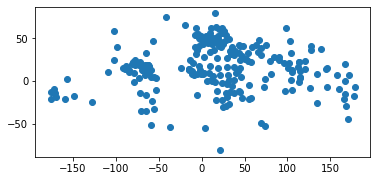

In [177]:
gdf.plot()

In [180]:
df2.to_csv('/Users/sofia/Documents/HE_Data/NRC/NRC_2022/NRC_final_20220623.csv')
gdf.to_file('/Users/sofia/Documents/HE_Data/NRC/NRC_2022/NRC_final_20220623.geojson', driver='GeoJSON')